In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import skforecast
print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


In [2]:
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
from skforecast.drift_detection import PopulationDriftDetector, PopulationDriftDetector
import nannyml as nml

In [3]:
data = fetch_dataset('bike_sharing')
data.head(3)

╭───────────────────────────────── bike_sharing ──────────────────────────────────╮
│ Description:                                                                    │
│ Hourly usage of the bike share system in the city of Washington D.C. during the │
│ years 2011 and 2012. In addition to the number of users per hour, information   │
│ about weather conditions and holidays is available.                             │
│                                                                                 │
│ Source:                                                                         │
│ Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.   │
│ https://doi.org/10.24432/C5W894.                                                │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/bike_sharing_dataset_clean.csv                               │
│                                                                                 │
│ Shape: 17544 rows x 11 columns                                                  │
╰─────────────────────────────────────────────────────────────────────────────────╯

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5


In [4]:
data_train = data.iloc[: len(data)//2].copy()
data_new  = data.iloc[len(data)//2 :].copy()
print(f'Train: {data_train.shape}, Test: {data_new.shape}')
data_train['weather'] = data_train['weather'].astype('category')
data_new['weather'] = pd.Categorical(data_new['weather'], categories=data_train['weather'].cat.categories)

Train: (8772, 11), Test: (8772, 11)


In [5]:
# Calculate statistics using nannyml
# =============================================================================
detector = nml.UnivariateDriftCalculator(
    column_names=data_train.columns.tolist(),
    timestamp_column_name="date_time",  # optional if you have time
    chunk_period='M',                   # optional if you have time
    categorical_methods=['chi2', 'jensen_shannon'],
    continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
)
detector.fit(reference_data=data_train.reset_index())
results = detector.calculate(data=data_new.reset_index())

In [6]:
results_nannyml = results.filter(period='analysis').to_df(multilevel=False)
results_nannyml.head(3)

,chunk_key,chunk_index,chunk_start_index,chunk_end_index,chunk_start_date,chunk_end_date,chunk_period,atemp_kolmogorov_smirnov_value,atemp_kolmogorov_smirnov_upper_threshold,atemp_kolmogorov_smirnov_lower_threshold,...,workingday_jensen_shannon_lower_threshold,workingday_jensen_shannon_alert,weather_chi2_value,weather_chi2_upper_threshold,weather_chi2_lower_threshold,weather_chi2_alert,weather_jensen_shannon_value,weather_jensen_shannon_upper_threshold,weather_jensen_shannon_lower_threshold,weather_jensen_shannon_alert
0,2012-01,0,0,731,2012-01-01,2012-01-31 23:59:59.999999999,analysis,0.492026,0.95185,None,...,None,False,2.699410,None,None,False,0.026844,0.447542,None,False
1,2012-02,1,732,1427,2012-02-01,2012-02-29 23:59:59.999999999,analysis,0.489746,0.95185,None,...,None,False,0.319118,None,None,False,0.009387,0.447542,None,False
2,2012-03,2,1428,2171,2012-03-01,2012-03-31 23:59:59.999999999,analysis,0.222809,0.95185,None,...,None,False,9.970343,None,None,True,0.055408,0.447542,None,False


In [7]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

# figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='drift')
# figure.show()

# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

# figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='distribution')
# figure.show()

In [25]:
detector = PopulationDriftDetector(
    chunk_size='ME',            
    threshold=0.99
)
detector.fit(data_train)
results_skforecast = detector.predict(data_new)
results_skforecast.head(3)

,chunk,chunk_start,chunk_end,feature,ks_statistic,chi2_statistic,jensen_shannon,threshold_ks,threshold_chi2,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
0,0,2012-01-01 12:00:00,2012-01-31 23:00:00,holiday,0.036162,NaN,0.073079,0.036314,NaN,0.121919,"(0.0, 1.0)",False,False,False,False,False
1,1,2012-02-01 00:00:00,2012-02-29 23:00:00,holiday,0.005071,NaN,0.012252,0.036314,NaN,0.121919,"(0.0, 1.0)",False,False,False,False,False
2,2,2012-03-01 00:00:00,2012-03-31 23:00:00,holiday,0.029412,NaN,0.121919,0.036314,NaN,0.121919,"(0.0, 1.0)",False,False,False,False,False


In [ ]:
# Test that statistics are equivalent to nannyml
# =============================================================================
features = results_skforecast["feature"].unique()
for feature in features:
    print(f"Feature: {feature}")
    cols = [
        "chunk_index",
        "chunk_start_date",
        "chunk_end_date",
        f"{feature}_kolmogorov_smirnov_value",
        f"{feature}_jensen_shannon_value",
        f"{feature}_chi2_value",
    ]
    # select columns if they exist in results_skforecast
    cols = [col for col in cols if col in results_nannyml.columns]
    df_nannyml = results_nannyml[cols].copy()
    df_nannyml = df_nannyml.rename(
        columns={
            "chunk_index": "chunk",
            "chunk_start_date": "chunk_start",
            "chunk_end_date": "chunk_end",
            f"{feature}_kolmogorov_smirnov_value": "ks_statistic",
            f"{feature}_jensen_shannon_value": "jensen_shannon",
            f"{feature}_chi2_value": "chi2_statistic",
        }
    )
    df_nannyml["feature"] = feature
    if "chi2_statistic" not in df_nannyml.columns:
        df_nannyml["chi2_statistic"] = np.nan
    if "ks_statistic" not in df_nannyml.columns:
        df_nannyml["ks_statistic"] = np.nan
    if "jensen_shannon" not in df_nannyml.columns:
        df_nannyml["jensen_shannon"] = np.nan

    df_nannyml = df_nannyml[
        [
            "chunk",
            "chunk_start",
            "chunk_end",
            "feature",
            "ks_statistic",
            "chi2_statistic",
            "jensen_shannon",
        ]
    ]

    df_skforecast = results_skforecast.query(f"feature == '{feature}'")[
        [
            "chunk",
            "chunk_start",
            "chunk_end",
            "feature",
            "ks_statistic",
            "chi2_statistic",
            "jensen_shannon",
        ]
    ]

    df_all = pd.merge(
        df_nannyml,
        df_skforecast,
        on=["chunk", "chunk_start", "feature"],
        suffixes=("_nannyml", "_skforecast"),
    )
    pd.testing.assert_series_equal(
        df_all["ks_statistic_nannyml"],
        df_all["ks_statistic_skforecast"],
        check_names=False,
    )
    pd.testing.assert_series_equal(
        df_all["chi2_statistic_nannyml"],
        df_all["chi2_statistic_skforecast"],
        check_names=False,
    )
    pd.testing.assert_series_equal(
        df_all["jensen_shannon_nannyml"],
        df_all["jensen_shannon_skforecast"],
        check_names=False,
    )

Feature: holiday
Feature: workingday
Feature: weather
Feature: temp
Feature: atemp
Feature: hum
Feature: windspeed
Feature: users
Feature: month
Feature: hour
Feature: weekday


In [20]:
# Multiseries
# =============================================================================
series = []
for i in range(20):
    df_temp = data.copy()
    df_temp['series'] = f'series_{i}'
    series.append(df_temp)
series = pd.concat(series)
series = series.set_index('series', append=True).swaplevel().sort_index()
series

holiday  workingday weather   temp   atemp  \
series   date_time                                                         
series_0 2011-01-01 00:00:00      0.0         0.0   clear   9.84  14.395   
         2011-01-01 01:00:00      0.0         0.0   clear   9.02  13.635   
         2011-01-01 02:00:00      0.0         0.0   clear   9.02  13.635   
         2011-01-01 03:00:00      0.0         0.0   clear   9.84  14.395   
         2011-01-01 04:00:00      0.0         0.0   clear   9.84  14.395   
...                               ...         ...     ...    ...     ...   
series_9 2012-12-31 19:00:00      0.0         1.0    mist  10.66  12.880   
         2012-12-31 20:00:00      0.0         1.0    mist  10.66  12.880   
         2012-12-31 21:00:00      0.0         1.0   clear  10.66  12.880   
         2012-12-31 22:00:00      0.0         1.0   clear  10.66  13.635   
         2012-12-31 23:00:00      0.0         1.0   clear  10.66  13.635   

                               hum  windspeed  users  month  hour  weekday  
series   date_time                                                          
series_0 2011-01-01 00:00:00  81.0     0.0000   16.0      1     0        5  
         2011-01-01 01:00:00  80.0     0.0000   40.0      1     1        5  
         2011-01-01 02:00:00  80.0     0.0000   32.0      1     2        5  
         2011-01-01 03:00:00  75.0     0.0000   13.0      1     3        5  
         2011-01-01 04:00:00  75.0     0.0000    1.0      1     4        5  
...                            ...        ...    ...    ...   ...      ...  
series_9 2012-12-31 19:00:00  60.0    11.0014  119.0     12    19        0  
         2012-12-31 20:00:00  60.0    11.0014   89.0     12    20        0  
         2012-12-31 21:00:00  60.0    11.0014   90.0     12    21        0  
         2012-12-31 22:00:00  56.0     8.9981   61.0     12    22        0  
         2012-12-31 23:00:00  65.0     8.9981   49.0     12    23        0  

[350880 rows x 11 columns]

In [21]:
detector = PopulationDriftDetector(
    chunk_size='ME',            
    threshold=0.99
)
detector.fit(series)

In [24]:
detector.empirical_threshold_chi2_

{}

In [44]:
results_skforecast = detector.predict(series)
results_skforecast

,level_0,chunk,chunk_start,chunk_end,feature,ks_statistic,chi2_statistic,jensen_shannon,threshold_ks,threshold_chi2,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
0,series_0,0,2011-01-01,2011-01-31 23:00:00,holiday,0.018633,NaN,0.041028,0.036913,NaN,0.122633,"(0.0, 1.0)",False,False,False,False,False
1,series_0,1,2011-02-01,2011-02-28 23:00:00,holiday,0.014889,NaN,0.033519,0.036913,NaN,0.122633,"(0.0, 1.0)",False,False,False,False,False
2,series_0,2,2011-03-01,2011-03-31 23:00:00,holiday,0.029754,NaN,0.122633,0.036913,NaN,0.122633,"(0.0, 1.0)",False,False,False,False,False
3,series_0,3,2011-04-01,2011-04-30 23:00:00,holiday,0.003580,NaN,0.008699,0.036913,NaN,0.122633,"(0.0, 1.0)",False,False,False,False,False
4,series_0,4,2011-05-01,2011-05-31 23:00:00,holiday,0.002504,NaN,0.006136,0.036913,NaN,0.122633,"(0.0, 1.0)",False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,series_9,19,2012-08-01,2012-08-31 23:00:00,weekday,0.029213,NaN,0.048686,0.055690,NaN,0.048686,"(0, 6)",False,False,False,False,False
5276,series_9,20,2012-09-01,2012-09-30 23:00:00,weekday,0.046056,NaN,0.042313,0.055690,NaN,0.048686,"(0, 6)",False,False,False,False,False
5277,series_9,21,2012-10-01,2012-10-31 23:00:00,weekday,0.055690,NaN,0.047537,0.055690,NaN,0.048686,"(0, 6)",False,False,False,False,False
5278,series_9,22,2012-11-01,2012-11-30 23:00:00,weekday,0.028181,NaN,0.044891,0.055690,NaN,0.048686,"(0, 6)",False,False,False,False,False


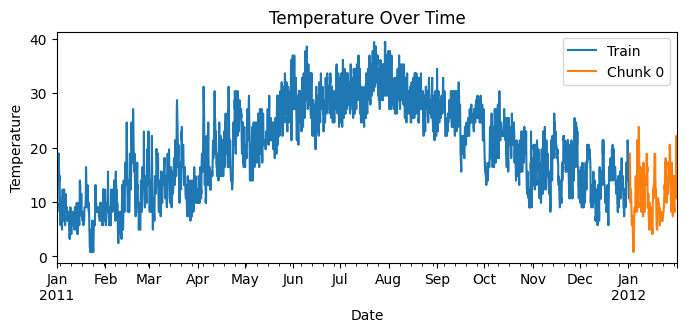

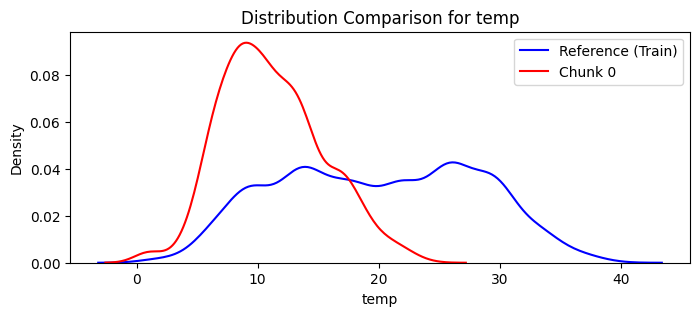

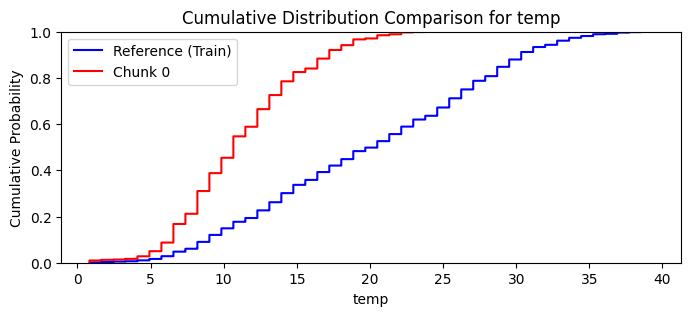

<Figure size 800x300 with 0 Axes>

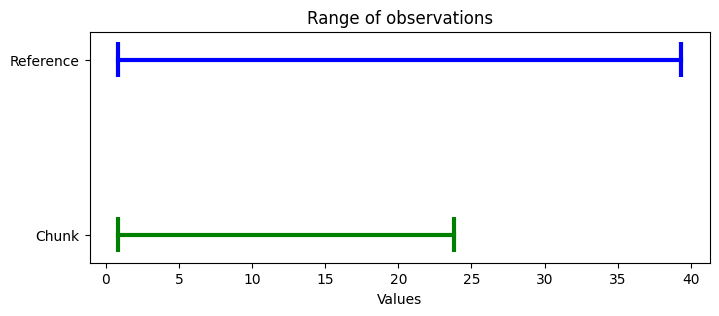

In [11]:
from matplotlib import pyplot as plt

# Plot time series
fig, ax = plt.subplots(figsize=(8, 3))
chunck_start = '2012-01-01 22:00:00'
chunck_end = '2012-01-31 23:00:00'
data_train.loc[:, 'temp'].plot(ax=ax, label='Train')
data_new.loc[chunck_start:chunck_end, 'temp'].plot(ax=ax, label='Chunk 0')
ax.set_title('Temperature Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()

# Compare distributions using kdeplot
import seaborn as sns
feature = 'temp'
chunk_data = data_new.loc[chunck_start:chunck_end, feature]
ref_data = data_train[feature]
plt.figure(figsize=(8, 3))
sns.kdeplot(ref_data, label='Reference (Train)', color='blue')
sns.kdeplot(chunk_data, label='Chunk 0', color='red')
plt.title(f'Distribution Comparison for {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

# Compare cumulative distributions
plt.figure(figsize=(8, 3))
sns.ecdfplot(ref_data, label='Reference (Train)', color='blue')
sns.ecdfplot(chunk_data, label='Chunk 0', color='red')
plt.title(f'Cumulative Distribution Comparison for {feature}')
plt.xlabel(feature)
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Visual comparison of ranges with violin plot
plt.figure(figsize=(8, 3))
min_reference = ref_data.min()
max_reference = ref_data.max()
min_chunk = chunk_data.min()
max_chunk = chunk_data.max()

plt.figure(figsize=(8, 3))
plt.plot([min_reference, max_reference], [0, 0], color='blue', linewidth=3)
plt.vlines([min_reference, max_reference], -0.1, 0.1, color='blue', linewidth=3)
plt.plot([min_chunk, max_chunk], [1, 1], color='green', linewidth=3)
plt.vlines([min_chunk, max_chunk], 0.9, 1.1, color='green', linewidth=3)
plt.yticks([0, 1], ['Reference', 'Chunk'])
plt.xlabel("Values")
plt.title("Range of observations")
plt.gca().invert_yaxis()
plt.show();


/tmp/ipykernel_10741/3421191882.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['dataset', feature])


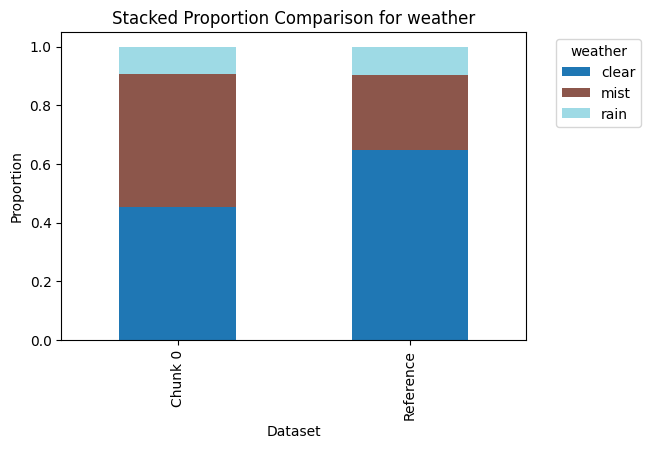

In [12]:
# Plot to compare distrubution of two categorical features
# ==============================================================================
feature = 'weather'
chunck_start = '2012-12-01 00:00:00'
chunck_end = '2012-12-31 23:00:00'
# Combine reference and chunk into one DataFrame
df = pd.concat([
    pd.DataFrame({feature: data_train[feature], 'dataset': 'Reference'}),
    pd.DataFrame({feature: data_new.loc[chunck_start:chunck_end, feature], 'dataset': 'Chunk 0'})
])

df_counts = (
    df.groupby(['dataset', feature])
      .size()
      .unstack(fill_value=0)  # categories become columns
)
df_props = df_counts.div(df_counts.sum(axis=1), axis=0)  # row-wise normalization

ax = df_props.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='tab20')
plt.title(f'Stacked Proportion Comparison for {feature}')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()